In [43]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

#from ignite.metrics.classification_report import ClassificationReport
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [44]:
df_raw = pd.read_csv("annthyroid.csv", header=None)

df_raw

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.750000,1,0,1,1,1,1,1,0,1,...,1,1,1,1,0.001132,0.080780,0.197324,0.300926,0.225000,1
1,0.239583,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0.000472,0.164345,0.235786,0.537037,0.165625,1
2,0.479167,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0.003585,0.130919,0.167224,0.527778,0.118750,1
3,0.656250,0,1,1,1,1,1,1,1,1,...,1,1,1,1,0.001698,0.091922,0.125418,0.337963,0.129688,1
4,0.229167,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0.000472,0.142061,0.229097,0.337963,0.235938,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7085,0.604167,1,1,1,1,1,1,1,1,1,...,1,1,1,0,0.004717,0.113092,0.128763,0.379630,0.121875,1
7086,0.520833,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0.200000,0.030641,0.005017,0.333333,0.005469,-1
7087,0.520833,1,1,1,1,1,1,1,1,1,...,1,1,1,0,0.001434,0.109192,0.147157,0.231481,0.206250,1
7088,0.354167,0,1,1,1,1,1,1,1,1,...,1,1,1,1,0.005283,0.109192,0.147157,0.333333,0.154688,1


In [45]:
device = "cpu"

In [46]:
y = df_raw[21]

y = torch.Tensor(y.values).to(device).detach().cpu().numpy()

y

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [47]:
x = df_raw.iloc[:,:-1]

#x = (x - x.min()) / (x.max() - x.min())

x = torch.Tensor(x.values).to(device)

x

tensor([[0.7500, 1.0000, 0.0000,  ..., 0.1973, 0.3009, 0.2250],
        [0.2396, 1.0000, 1.0000,  ..., 0.2358, 0.5370, 0.1656],
        [0.4792, 1.0000, 1.0000,  ..., 0.1672, 0.5278, 0.1187],
        ...,
        [0.5208, 1.0000, 1.0000,  ..., 0.1472, 0.2315, 0.2062],
        [0.3542, 0.0000, 1.0000,  ..., 0.1472, 0.3333, 0.1547],
        [0.7500, 1.0000, 1.0000,  ..., 0.1321, 0.3380, 0.1375]])

In [48]:
class Autoencoder(nn.Module):
    # Layers is an array of integers representing the encoder architecture
    # Example: 30 --> 3 --> 30: layers = [30, 3]
    def __init__(self, layers):
        super().__init__()
        self.in_dim = layers[0]
        self.activation = nn.Sigmoid()
        self.layers = layers
        
        # Encoder
        self.encoder_layers = []
        
        for i in range(len(layers) - 1):
            self.encoder_layers.append(nn.Linear(layers[i], layers[i+1]))
            self.encoder_layers.append(nn.Sigmoid())
        
        self.encoder_sequence = nn.Sequential(*self.encoder_layers)
            
        # Decoder
        self.decoder_layers = []
        
#         for i in range(len(layers) - 1, 0, -1):
#             self.decoder_layers.append(nn.Linear(layers[i], layers[i - 1]))
#             self.decoder_layers.append(nn.Sigmoid())
    
#         layers.reverse()
#         for i in range(len(layers) - 1):
#             self.decoder_layers.append(nn.Linear(layers[i], layers[i+1]))
#             self.decoder_layers.append(nn.Sigmoid())

        reversed_layers = sorted(layers, reverse=False)
        for i in range(len(reversed_layers) - 1):
            self.decoder_layers.append(nn.Linear(reversed_layers[i], reversed_layers[i+1]))
            self.decoder_layers.append(nn.Sigmoid())
        
        self.decoder_sequence = nn.Sequential(*self.decoder_layers)
        
    def encode(self, x):
        return self.encoder_sequence(x)
    
    def decode(self, x):
        return self.decoder_sequence(x)
    
    def forward(self, x):
        x = self.encode(x)
        y = self.decode(x)
        return y

In [49]:
model = Autoencoder([21, 20, 3])

print(model)

Autoencoder(
  (activation): Sigmoid()
  (encoder_sequence): Sequential(
    (0): Linear(in_features=21, out_features=20, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=20, out_features=3, bias=True)
    (3): Sigmoid()
  )
  (decoder_sequence): Sequential(
    (0): Linear(in_features=3, out_features=20, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=20, out_features=21, bias=True)
    (3): Sigmoid()
  )
)


In [50]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class AutoencoderDataset(Dataset):
    def __init__(self, x):
        self.x = x
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.x[index]

In [51]:
learning_rate = 0.01
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 5

In [52]:
# Define the training process
# Each call of the train function == 1 Epoch
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        predictions = model.forward(data)
        
        loss = loss_fn(predictions, targets)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

# use Dataloader for Autoencoder 
custom_dataset = AutoencoderDataset(x)

# partition into train and validaton
train_size = int(0.8 * len(custom_dataset))
test_size = len(custom_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(custom_dataset, [train_size, test_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

epochs = 100
losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))
    
    state = { 'state_dict': model.state_dict() }

    torch.save(state, "autoencoder_1.pth")

Epoch: 0


100%|██████████| 1135/1135 [00:04<00:00, 265.63it/s, loss=0.0519] 


Ave Loss: 0.02855624897602437
Epoch: 1


100%|██████████| 1135/1135 [00:03<00:00, 301.12it/s, loss=0.0525] 


Ave Loss: 0.01963292140727001
Epoch: 2


100%|██████████| 1135/1135 [00:04<00:00, 275.84it/s, loss=0.0522] 


Ave Loss: 0.019402191961709295
Epoch: 3


100%|██████████| 1135/1135 [00:04<00:00, 281.60it/s, loss=0.052]  


Ave Loss: 0.01915265404247978
Epoch: 4


100%|██████████| 1135/1135 [00:04<00:00, 277.12it/s, loss=0.0517] 


Ave Loss: 0.01680563232422466
Epoch: 5


100%|██████████| 1135/1135 [00:04<00:00, 258.57it/s, loss=0.0523] 


Ave Loss: 0.015509411117466093
Epoch: 6


100%|██████████| 1135/1135 [00:04<00:00, 277.63it/s, loss=0.0528]  


Ave Loss: 0.014687469074428737
Epoch: 7


100%|██████████| 1135/1135 [00:04<00:00, 276.45it/s, loss=0.0532]  


Ave Loss: 0.014160361805713288
Epoch: 8


100%|██████████| 1135/1135 [00:04<00:00, 281.45it/s, loss=0.0531]  


Ave Loss: 0.014057938818869053
Epoch: 9


100%|██████████| 1135/1135 [00:04<00:00, 267.52it/s, loss=0.0531]  


Ave Loss: 0.013918325324575643
Epoch: 10


100%|██████████| 1135/1135 [00:04<00:00, 251.04it/s, loss=0.0536]  


Ave Loss: 0.013893722965626153
Epoch: 11


100%|██████████| 1135/1135 [00:04<00:00, 271.08it/s, loss=0.0525]  


Ave Loss: 0.013598912395075342
Epoch: 12


100%|██████████| 1135/1135 [00:04<00:00, 269.83it/s, loss=0.0529]  


Ave Loss: 0.013094874773644289
Epoch: 13


100%|██████████| 1135/1135 [00:04<00:00, 266.30it/s, loss=0.0534]  


Ave Loss: 0.012413670855732266
Epoch: 14


100%|██████████| 1135/1135 [00:03<00:00, 299.96it/s, loss=0.0438]  


Ave Loss: 0.011522512835304822
Epoch: 15


100%|██████████| 1135/1135 [00:03<00:00, 297.85it/s, loss=0.0354]  


Ave Loss: 0.01066225803811575
Epoch: 16


100%|██████████| 1135/1135 [00:03<00:00, 290.62it/s, loss=0.0289]  


Ave Loss: 0.00954343168116749
Epoch: 17


100%|██████████| 1135/1135 [00:03<00:00, 296.76it/s, loss=0.0288]  


Ave Loss: 0.009354103313315872
Epoch: 18


100%|██████████| 1135/1135 [00:03<00:00, 300.09it/s, loss=0.0321]  


Ave Loss: 0.009470819183297062
Epoch: 19


100%|██████████| 1135/1135 [00:03<00:00, 284.09it/s, loss=0.0275]  


Ave Loss: 0.008776908244148906
Epoch: 20


100%|██████████| 1135/1135 [00:03<00:00, 285.65it/s, loss=0.0269]  


Ave Loss: 0.008354057791967988
Epoch: 21


100%|██████████| 1135/1135 [00:03<00:00, 297.32it/s, loss=0.0256]  


Ave Loss: 0.008049025813205832
Epoch: 22


100%|██████████| 1135/1135 [00:03<00:00, 291.01it/s, loss=0.0255]  


Ave Loss: 0.00809382004817201
Epoch: 23


100%|██████████| 1135/1135 [00:03<00:00, 300.89it/s, loss=0.0253]  


Ave Loss: 0.007791419528447305
Epoch: 24


100%|██████████| 1135/1135 [00:03<00:00, 296.74it/s, loss=0.0255]  


Ave Loss: 0.007945021470105541
Epoch: 25


100%|██████████| 1135/1135 [00:03<00:00, 294.01it/s, loss=0.0257]  


Ave Loss: 0.007824117779328656
Epoch: 26


100%|██████████| 1135/1135 [00:03<00:00, 291.18it/s, loss=0.0265]  


Ave Loss: 0.007785008039703954
Epoch: 27


100%|██████████| 1135/1135 [00:03<00:00, 297.41it/s, loss=0.0252]  


Ave Loss: 0.007740397738561543
Epoch: 28


100%|██████████| 1135/1135 [00:03<00:00, 287.33it/s, loss=0.0253]  


Ave Loss: 0.007827777631587497
Epoch: 29


100%|██████████| 1135/1135 [00:04<00:00, 283.28it/s, loss=0.0251]  


Ave Loss: 0.007610560172006163
Epoch: 30


100%|██████████| 1135/1135 [00:03<00:00, 286.92it/s, loss=0.0252]  


Ave Loss: 0.007548057159246356
Epoch: 31


100%|██████████| 1135/1135 [00:03<00:00, 288.69it/s, loss=0.0256]  


Ave Loss: 0.007756632208000532
Epoch: 32


100%|██████████| 1135/1135 [00:03<00:00, 295.82it/s, loss=0.0253]  


Ave Loss: 0.007547900976681372
Epoch: 33


100%|██████████| 1135/1135 [00:03<00:00, 295.56it/s, loss=0.0254]  


Ave Loss: 0.007563959273121459
Epoch: 34


100%|██████████| 1135/1135 [00:03<00:00, 285.22it/s, loss=0.0256]  


Ave Loss: 0.007765063863041983
Epoch: 35


100%|██████████| 1135/1135 [00:04<00:00, 270.65it/s, loss=0.0262]  


Ave Loss: 0.0074521736337906895
Epoch: 36


100%|██████████| 1135/1135 [00:03<00:00, 286.79it/s, loss=0.0255]  


Ave Loss: 0.007686935928673279
Epoch: 37


100%|██████████| 1135/1135 [00:03<00:00, 296.90it/s, loss=0.0256]  


Ave Loss: 0.00753483442939143
Epoch: 38


100%|██████████| 1135/1135 [00:04<00:00, 268.40it/s, loss=0.0378]  


Ave Loss: 0.007813082853258312
Epoch: 39


100%|██████████| 1135/1135 [00:03<00:00, 286.02it/s, loss=0.0262]  


Ave Loss: 0.00989693888271533
Epoch: 40


100%|██████████| 1135/1135 [00:04<00:00, 278.99it/s, loss=0.0253]  


Ave Loss: 0.00936951199242597
Epoch: 41


100%|██████████| 1135/1135 [00:04<00:00, 276.57it/s, loss=0.0263]  


Ave Loss: 0.009231394123530122
Epoch: 42


100%|██████████| 1135/1135 [00:04<00:00, 255.75it/s, loss=0.0255]  


Ave Loss: 0.009281692493054093
Epoch: 43


100%|██████████| 1135/1135 [00:04<00:00, 249.00it/s, loss=0.0253]  


Ave Loss: 0.009164356990637348
Epoch: 44


100%|██████████| 1135/1135 [00:04<00:00, 258.98it/s, loss=0.0254]  


Ave Loss: 0.009215508920544685
Epoch: 45


100%|██████████| 1135/1135 [00:04<00:00, 262.79it/s, loss=0.0256]  


Ave Loss: 0.009557319908697232
Epoch: 46


100%|██████████| 1135/1135 [00:04<00:00, 274.88it/s, loss=0.0251]  


Ave Loss: 0.009180629666405423
Epoch: 47


100%|██████████| 1135/1135 [00:04<00:00, 279.44it/s, loss=0.0251]  


Ave Loss: 0.009120988802220734
Epoch: 48


100%|██████████| 1135/1135 [00:03<00:00, 286.57it/s, loss=0.0255]  


Ave Loss: 0.009163076119545626
Epoch: 49


100%|██████████| 1135/1135 [00:04<00:00, 271.98it/s, loss=0.0251]  


Ave Loss: 0.00916842319876969
Epoch: 50


100%|██████████| 1135/1135 [00:04<00:00, 257.56it/s, loss=0.0256]  


Ave Loss: 0.009282342281558198
Epoch: 51


100%|██████████| 1135/1135 [00:04<00:00, 282.41it/s, loss=0.025]   


Ave Loss: 0.009041997106665835
Epoch: 52


100%|██████████| 1135/1135 [00:04<00:00, 281.53it/s, loss=0.0251]  


Ave Loss: 0.009152158164834124
Epoch: 53


100%|██████████| 1135/1135 [00:04<00:00, 280.65it/s, loss=0.025]   


Ave Loss: 0.009017155840539061
Epoch: 54


100%|██████████| 1135/1135 [00:04<00:00, 274.37it/s, loss=0.0256]  


Ave Loss: 0.009596893060408812
Epoch: 55


100%|██████████| 1135/1135 [00:04<00:00, 275.34it/s, loss=0.0251]  


Ave Loss: 0.008977521500908688
Epoch: 56


100%|██████████| 1135/1135 [00:04<00:00, 263.43it/s, loss=0.0251]  


Ave Loss: 0.00909625013798141
Epoch: 57


100%|██████████| 1135/1135 [00:03<00:00, 292.04it/s, loss=0.0251]  


Ave Loss: 0.009027312870295349
Epoch: 58


100%|██████████| 1135/1135 [00:04<00:00, 275.23it/s, loss=0.0279]  


Ave Loss: 0.009136451091458364
Epoch: 59


100%|██████████| 1135/1135 [00:04<00:00, 275.85it/s, loss=0.025]   


Ave Loss: 0.008950163459144778
Epoch: 60


100%|██████████| 1135/1135 [00:04<00:00, 277.98it/s, loss=0.0251]  


Ave Loss: 0.009039453637905702
Epoch: 61


100%|██████████| 1135/1135 [00:03<00:00, 284.42it/s, loss=0.0252]  


Ave Loss: 0.008920966275920988
Epoch: 62


100%|██████████| 1135/1135 [00:04<00:00, 255.70it/s, loss=0.0251]  


Ave Loss: 0.008909247964166724
Epoch: 63


100%|██████████| 1135/1135 [00:04<00:00, 239.54it/s, loss=0.0258]  


Ave Loss: 0.009043709098080395
Epoch: 64


100%|██████████| 1135/1135 [00:04<00:00, 271.40it/s, loss=0.0252]  


Ave Loss: 0.008916836186778312
Epoch: 65


100%|██████████| 1135/1135 [00:04<00:00, 276.14it/s, loss=0.025]   


Ave Loss: 0.008899888384352348
Epoch: 66


100%|██████████| 1135/1135 [00:04<00:00, 279.80it/s, loss=0.0249]  


Ave Loss: 0.008803058765435771
Epoch: 67


100%|██████████| 1135/1135 [00:05<00:00, 214.42it/s, loss=0.0251]  


Ave Loss: 0.00886432807451516
Epoch: 68


100%|██████████| 1135/1135 [00:04<00:00, 264.80it/s, loss=0.0248]  


Ave Loss: 0.008644047458945888
Epoch: 69


100%|██████████| 1135/1135 [00:04<00:00, 264.18it/s, loss=0.0252]  


Ave Loss: 0.008747524583439388
Epoch: 70


100%|██████████| 1135/1135 [00:04<00:00, 275.98it/s, loss=0.0248]  


Ave Loss: 0.008510946574975278
Epoch: 71


100%|██████████| 1135/1135 [00:03<00:00, 285.22it/s, loss=0.0251]  


Ave Loss: 0.008497084200775584
Epoch: 72


100%|██████████| 1135/1135 [00:04<00:00, 274.00it/s, loss=0.0248]  


Ave Loss: 0.00857528786179825
Epoch: 73


100%|██████████| 1135/1135 [00:05<00:00, 219.08it/s, loss=0.0253]  


Ave Loss: 0.008503968533426462
Epoch: 74


100%|██████████| 1135/1135 [00:04<00:00, 275.65it/s, loss=0.0247]  


Ave Loss: 0.008636633426875148
Epoch: 75


100%|██████████| 1135/1135 [00:04<00:00, 246.11it/s, loss=0.0272]  


Ave Loss: 0.008423385524887403
Epoch: 76


100%|██████████| 1135/1135 [00:04<00:00, 276.65it/s, loss=0.0257]  


Ave Loss: 0.008604939242169499
Epoch: 77


100%|██████████| 1135/1135 [00:04<00:00, 282.60it/s, loss=0.0248]  


Ave Loss: 0.008381703304111986
Epoch: 78


100%|██████████| 1135/1135 [00:04<00:00, 279.75it/s, loss=0.0254]  


Ave Loss: 0.008843987134063723
Epoch: 79


100%|██████████| 1135/1135 [00:04<00:00, 273.42it/s, loss=0.0247]  


Ave Loss: 0.008831855268109926
Epoch: 80


100%|██████████| 1135/1135 [00:04<00:00, 272.64it/s, loss=0.0246]  


Ave Loss: 0.008420005283653859
Epoch: 81


100%|██████████| 1135/1135 [00:04<00:00, 280.83it/s, loss=0.0248]  


Ave Loss: 0.008479648211082168
Epoch: 82


100%|██████████| 1135/1135 [00:04<00:00, 265.71it/s, loss=0.0248]  


Ave Loss: 0.008362301917580502
Epoch: 83


100%|██████████| 1135/1135 [00:04<00:00, 274.19it/s, loss=0.0249]  


Ave Loss: 0.008401856271525444
Epoch: 84


100%|██████████| 1135/1135 [00:04<00:00, 277.71it/s, loss=0.0252]  


Ave Loss: 0.008584687042399822
Epoch: 85


100%|██████████| 1135/1135 [00:04<00:00, 275.38it/s, loss=0.0249]  


Ave Loss: 0.008111287642663677
Epoch: 86


100%|██████████| 1135/1135 [00:04<00:00, 278.67it/s, loss=0.025]   


Ave Loss: 0.008183341594987306
Epoch: 87


100%|██████████| 1135/1135 [00:04<00:00, 279.06it/s, loss=0.0306]  


Ave Loss: 0.008267273318849706
Epoch: 88


100%|██████████| 1135/1135 [00:04<00:00, 276.75it/s, loss=0.0269]  


Ave Loss: 0.008345034530325814
Epoch: 89


100%|██████████| 1135/1135 [00:04<00:00, 281.87it/s, loss=0.025]   


Ave Loss: 0.007892968175465566
Epoch: 90


100%|██████████| 1135/1135 [00:04<00:00, 281.57it/s, loss=0.025]   


Ave Loss: 0.007837796634979062
Epoch: 91


100%|██████████| 1135/1135 [00:04<00:00, 279.51it/s, loss=0.0503]  


Ave Loss: 0.008113976656436194
Epoch: 92


100%|██████████| 1135/1135 [00:04<00:00, 260.18it/s, loss=0.0254]  


Ave Loss: 0.007941441144576268
Epoch: 93


100%|██████████| 1135/1135 [00:04<00:00, 266.24it/s, loss=0.027]   


Ave Loss: 0.007721635203058257
Epoch: 94


100%|██████████| 1135/1135 [00:04<00:00, 250.10it/s, loss=0.0248]  


Ave Loss: 0.007792678228510228
Epoch: 95


100%|██████████| 1135/1135 [00:04<00:00, 250.53it/s, loss=0.0287]  


Ave Loss: 0.008187518522565433
Epoch: 96


100%|██████████| 1135/1135 [00:04<00:00, 259.80it/s, loss=0.0249]  


Ave Loss: 0.007684826287289667
Epoch: 97


100%|██████████| 1135/1135 [00:04<00:00, 254.58it/s, loss=0.0253]  


Ave Loss: 0.007656988082556177
Epoch: 98


100%|██████████| 1135/1135 [00:04<00:00, 252.23it/s, loss=0.025]   


Ave Loss: 0.00777144817351302
Epoch: 99


100%|██████████| 1135/1135 [00:04<00:00, 262.50it/s, loss=0.0248]  

Ave Loss: 0.00754943158039577


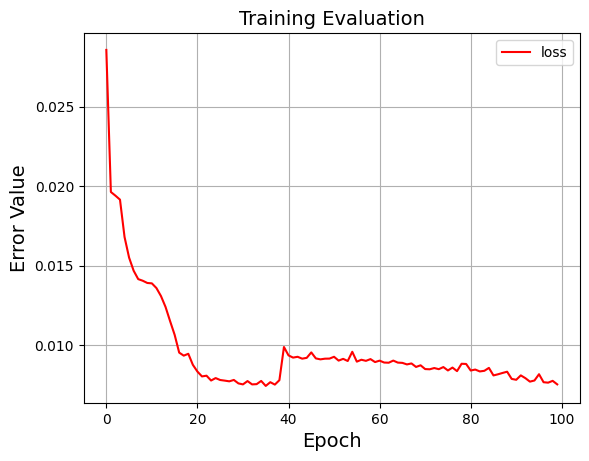

In [53]:
plt.plot(losses, label='loss', color='red')
plt.title('Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [54]:
compressed_data = model.encode(x)

df_compressed_data = pd.DataFrame(compressed_data.detach().cpu().numpy())
#df_compressed_data = pd.DataFrame(compressed_data)

x = torch.Tensor(df_compressed_data.values)

x

tensor([[0.0032, 0.9626, 0.2053],
        [0.3651, 0.9976, 0.2237],
        [0.3333, 0.9967, 0.1618],
        ...,
        [0.1409, 0.9986, 0.1434],
        [0.9990, 0.1330, 0.0025],
        [0.1312, 0.9978, 0.0838]])

In [55]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.hidden_layer_1 = nn.Linear(self.in_dim, 20) # input to first hidden layer
        self.hidden_layer_2 = nn.Linear(20, 10)
        
        self.multiple_layers = nn.Sequential(
            nn.Linear(10, 10),
            nn.Sigmoid(),
            nn.Linear(10, 10),
            nn.Sigmoid(),
            nn.Linear(10, 10),
            nn.Sigmoid(),
            nn.Linear(10, 10),
            nn.Sigmoid(),
        )
        
        self.output_layer = nn.Linear(10, self.out_dim)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x = self.hidden_layer_1(x)
        x = self.activation(x)
        
        x = self.hidden_layer_2(x)
        x = self.activation(x)
        
        x = self.multiple_layers(x)
        
        y = self.output_layer(x)
        y = self.activation(y)
        
        return y

In [56]:
model = NeuralNetwork(3, 2)

# Test structure of model
predictions = model.forward(x)

predictions = predictions.detach().cpu().numpy()

predictions



array([[0.46642816, 0.54406977],
       [0.4664283 , 0.5440699 ],
       [0.46642837, 0.5440699 ],
       ...,
       [0.46642828, 0.5440698 ],
       [0.46642858, 0.5440705 ],
       [0.46642828, 0.5440698 ]], dtype=float32)